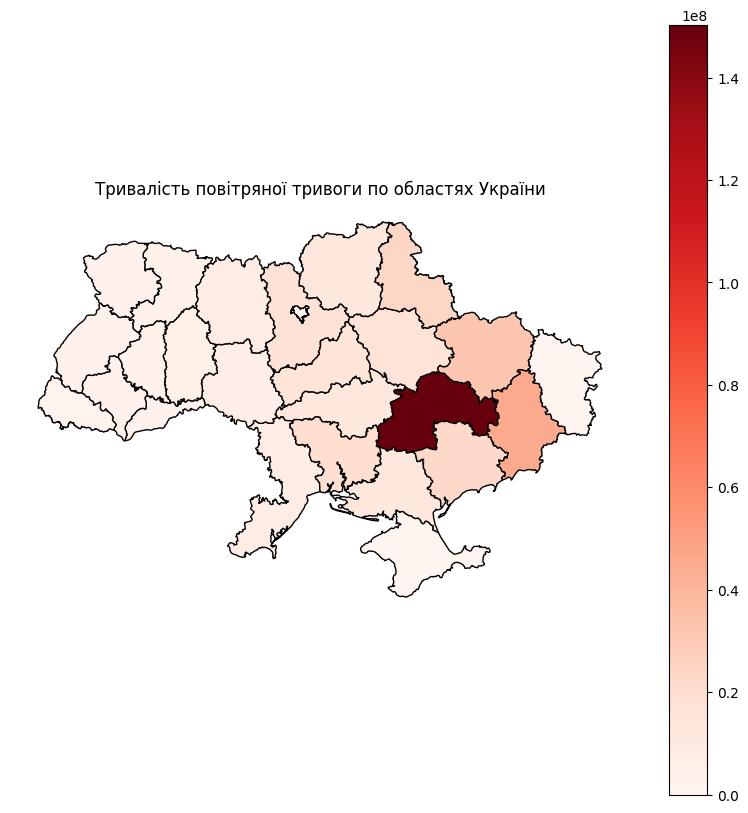

In [32]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt

# 1. Завантажуємо GeoJSON з межами областей
gdf = gpd.read_file("full_area_ukraine_geo_v07_08_2024.geojson")



df = pd.read_csv('air_alerts.csv')

df[['finished_at', 'started_at']] = df[['finished_at', 'started_at']].apply(pd.to_datetime)
df['duration'] = (df['finished_at'] - df['started_at']).dt.total_seconds()
df['oblast'] = df['oblast'].str.lower()
df['oblast'] = df['oblast'].replace('м. київ', 'київська область')


df = df.groupby('oblast', as_index=False)['duration'].sum()


# 3. З’єднуємо обидва датафрейми (назви мають співпадати!)
gdf['oblast'] = gdf['name:ua'].str.lower()  # або інша колонка з назвою області в geojson
merged = gdf.merge(df, on='oblast', how='left')
merged['duration'] = merged['duration'].fillna(0)

# 4. Малюємо мапу, зафарбовуючи по тривалості
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
merged.plot(column='duration', ax=ax, legend=True, cmap='Reds', edgecolor='black')
ax.set_title("Тривалість повітряної тривоги по областях України")
plt.axis('off')
plt.show()


In [21]:
df = df.groupby('oblast', as_index=False)['duration'].sum()
df

,oblast,duration
0,волинська область,2669799.0
1,вінницька область,6299138.0
2,дніпропетровська область,150374347.0
3,донецька область,45685311.0
4,житомирська область,7455590.0
5,закарпатська область,2280383.0
6,запорізька область,22432253.0
7,київська область,10945896.0
8,кіровоградська область,12555489.0
9,лубенський район,694.0


In [27]:
gdf['name:ua'].unique()

array(['Луганська область', 'Кіровоградська область', 'Одеська область',
       'Херсонська область', 'Миколаївська область',
       'Дніпропетровська область', 'Вінницька область',
       'Черкаська область', 'Чернігівська область', 'Чернівецька область',
       'Автономна Республіка Крим', 'Донецька область',
       'Івано-Франківська область', 'Харківська область',
       'Хмельницька область', 'Київська область', 'Львівська область',
       'Полтавська область', 'Рівненська область', 'Сумська область',
       'Тернопільська область', 'Волинська область',
       'Закарпатська область', 'Запорізька область',
       'Житомирська область', 'Київ'], dtype=object)